# Task-2

# Q_2 Audio

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import soundfile

%matplotlib inline
%config InlineBackend.figure_format = "retina"

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cpu


In [2]:
from IPython.display import Audio
Audio(filename=r'mixkit-suspense-movie-transition-sound-2910.wav')

In [3]:
import torchaudio
audio, sr = torchaudio.load(r'mixkit-suspense-movie-transition-sound-2910.wav')

In [4]:
print(audio.shape)
audio = audio[0]
tm = audio.shape[0] / sr
print(f"Audio length: {tm} seconds")

torch.Size([2, 250539])
Audio length: 5.681156462585034 seconds


In [5]:
def audio_plot(audio, sr, clr, tl):
    plt.figure(figsize=(15, 4))
    plt.plot(audio, color = clr, alpha = 0.7)
    plt.xticks(np.arange(0, audio.shape[0], sr), np.arange(0, audio.shape[0] / sr, 1))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(tl)
    plt.grid()
    plt.show()

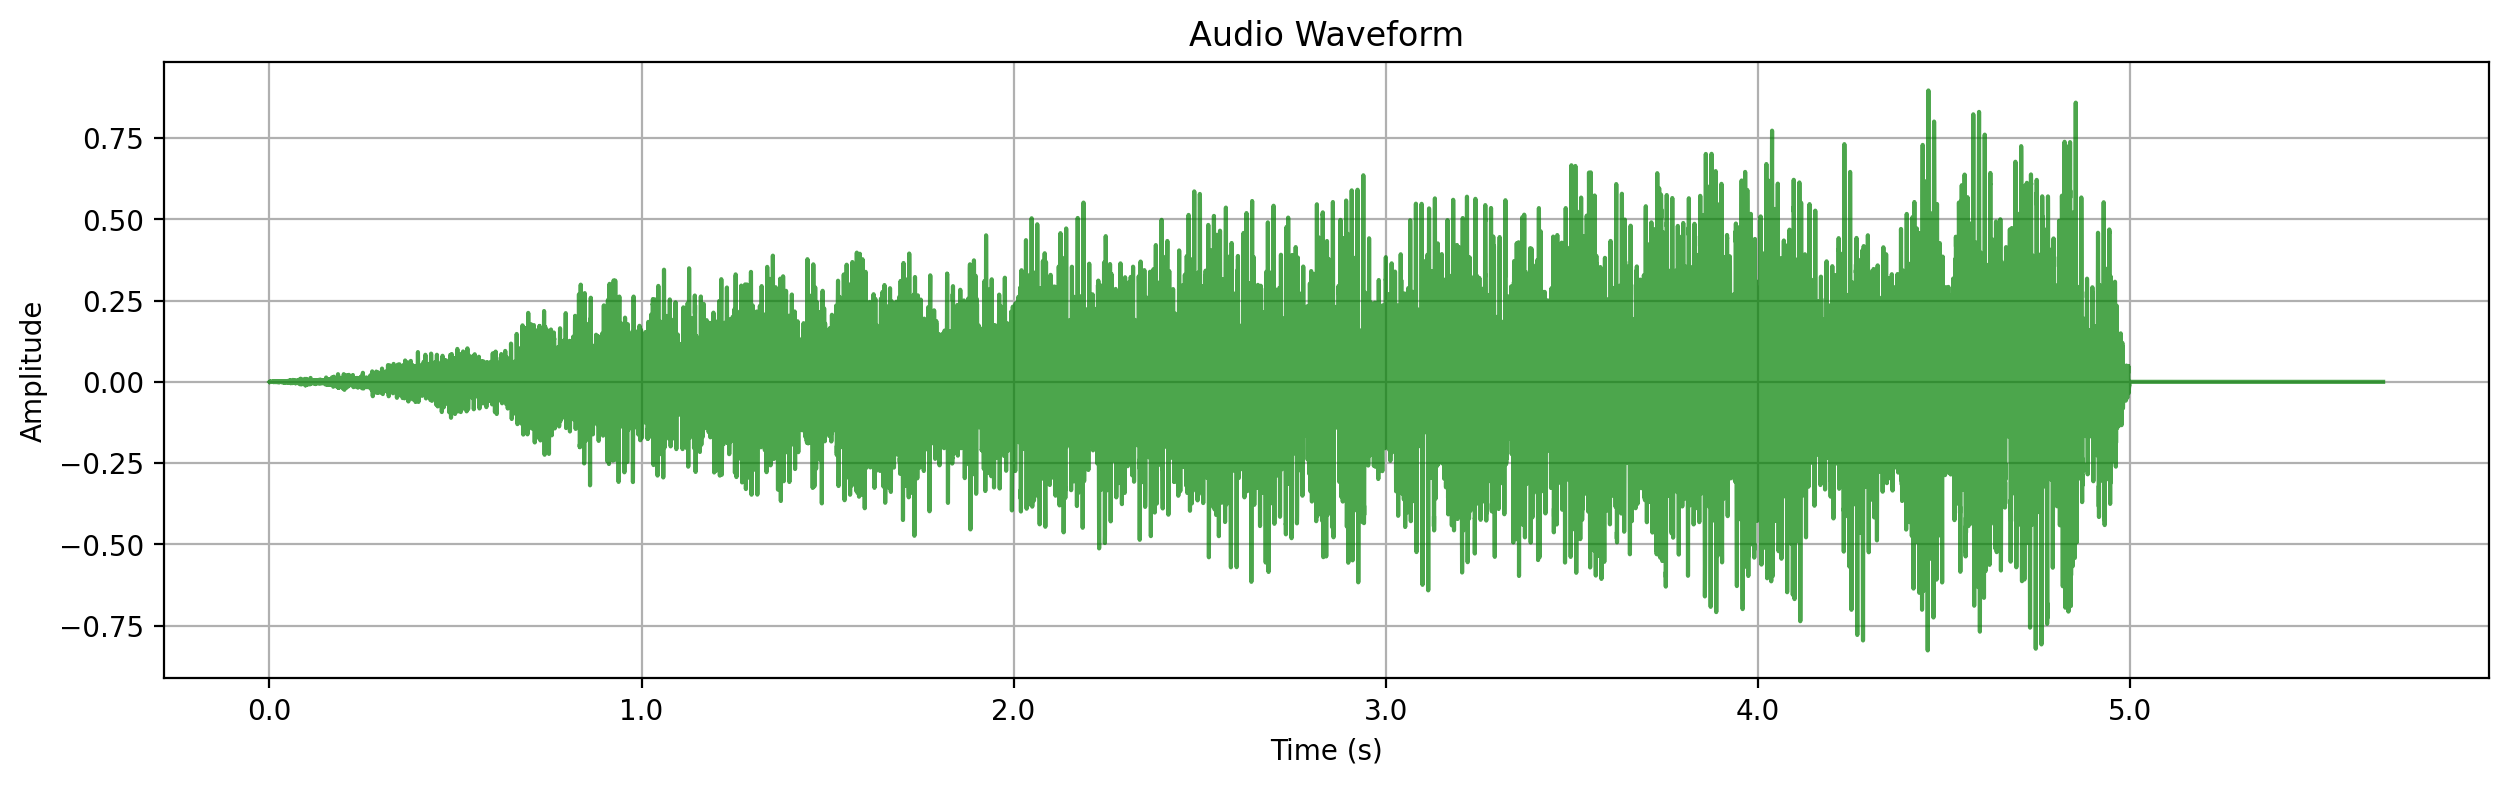

In [6]:
audio_plot(audio, sr, 'green', 'Audio Waveform')

### Using the last 2 seconds of the Audio

In [7]:
audio = audio[-2 * sr:]
print(audio.shape)
print(audio)

torch.Size([88200])
tensor([-1.2097e-01, -1.1371e-01, -1.0635e-01,  ..., -6.1035e-05,
         9.1553e-05, -9.1553e-05])


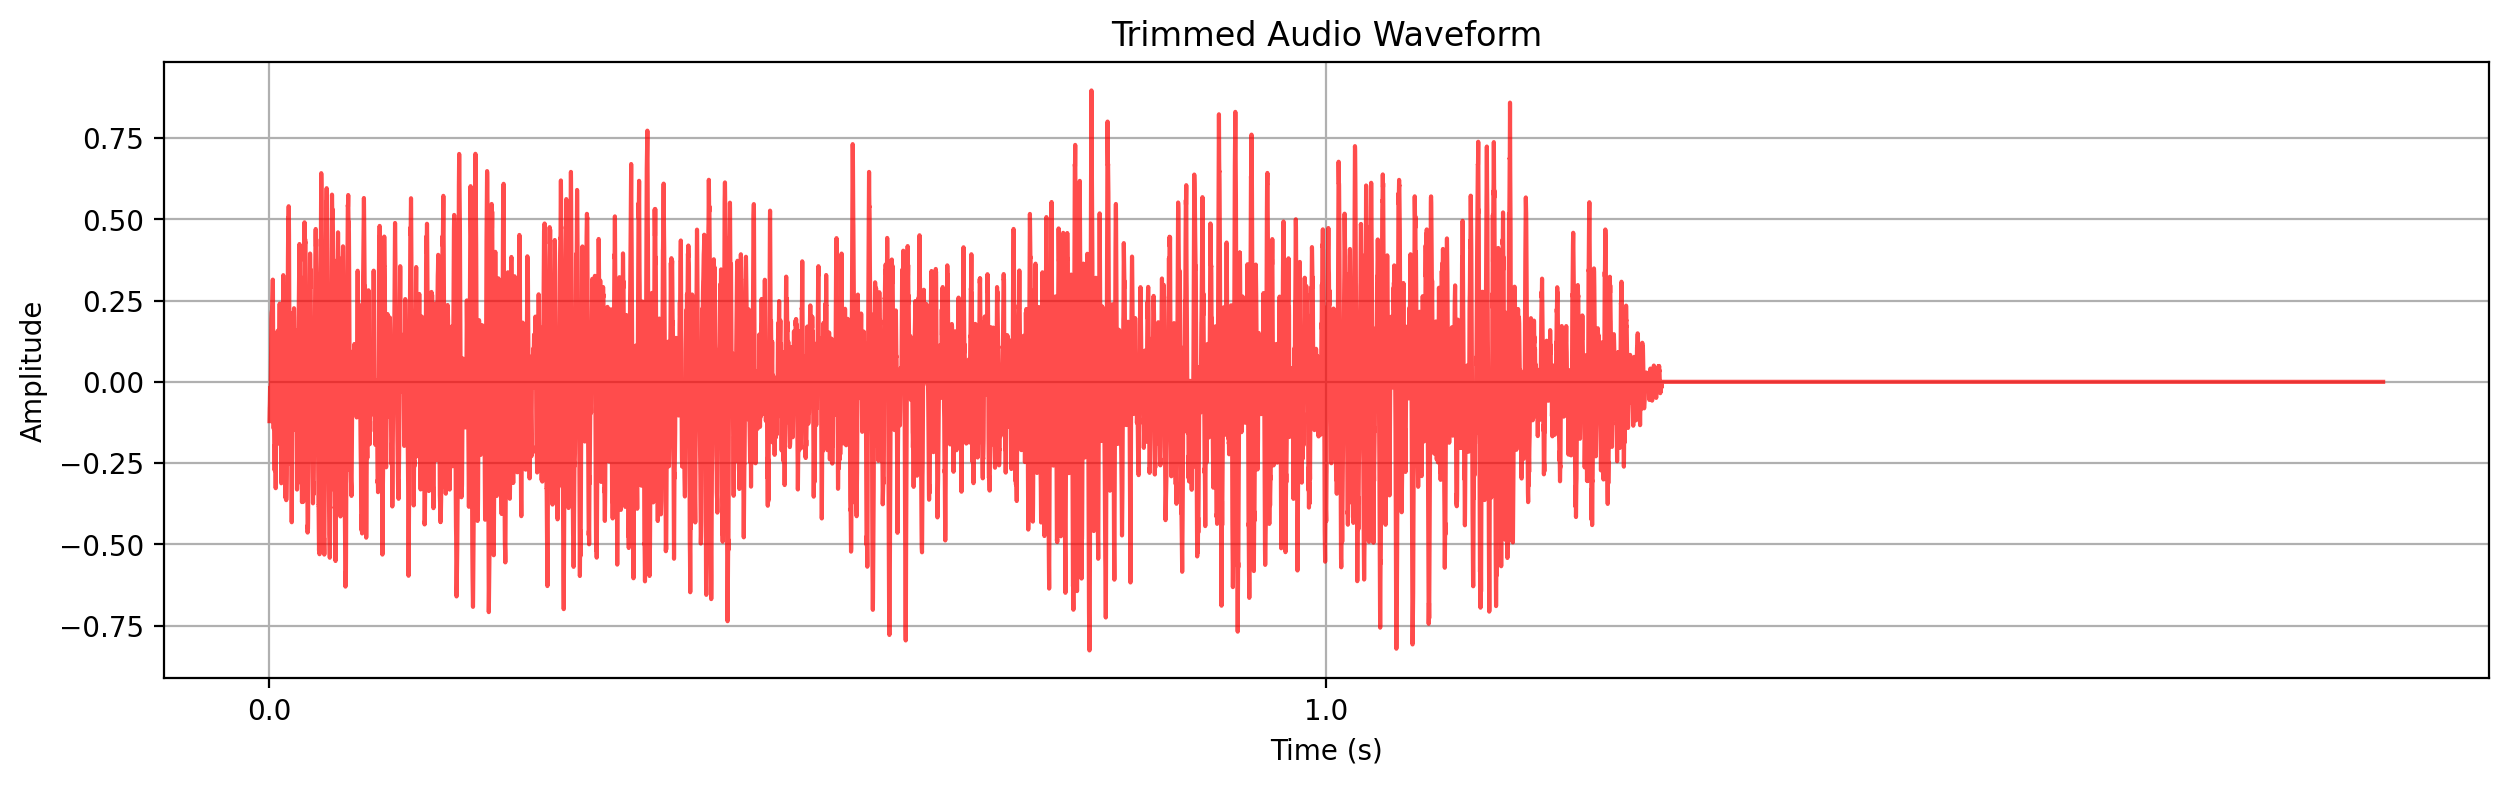

In [8]:
audio_plot(audio, sr, 'red', 'Trimmed Audio Waveform')

In [9]:
X = torch.arange(0, len(audio)).unsqueeze(1).float()
X = X / X.max() * 200 - 100
print(X.shape)
print(X)

torch.Size([88200, 1])
tensor([[-100.0000],
        [ -99.9977],
        [ -99.9955],
        ...,
        [  99.9955],
        [  99.9977],
        [ 100.0000]])


In [10]:
Audio(audio, rate = sr)

In [11]:
from sklearn.kernel_approximation import RBFSampler
def create_rff_features(X, num_features, sigma):
    rff = RBFSampler(n_components = num_features, gamma = 1 / (2 * sigma**2), random_state = 13)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype = torch.float32)

In [21]:
num_features = 15000
sigma = 0.008
X_rff = create_rff_features(X, num_features, sigma)
print(X_rff.shape)
print(X_rff)

torch.Size([88200, 15000])
tensor([[-0.0056, -0.0078,  0.0092,  ...,  0.0110, -0.0048, -0.0029],
        [-0.0075, -0.0094,  0.0091,  ...,  0.0115, -0.0033,  0.0043],
        [-0.0091, -0.0106,  0.0090,  ...,  0.0114, -0.0018,  0.0098],
        ...,
        [ 0.0021, -0.0108,  0.0054,  ...,  0.0104,  0.0115,  0.0073],
        [ 0.0043, -0.0114,  0.0053,  ...,  0.0091,  0.0115,  0.0112],
        [ 0.0064, -0.0115,  0.0052,  ...,  0.0073,  0.0114,  0.0107]])


In [22]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_rff.numpy(), audio)
pred_audio = model.predict(X_rff.numpy())
print(pred_audio.shape)

(88200,)


In [23]:
import joblib
joblib.dump(model, 'model.pkl')
model = joblib.load('model.pkl')
import soundfile as sf
sf.write('pred_audio.wav', pred_audio, sr)

In [24]:
print(pred_audio)
print(audio)

[-1.18471146e-01 -1.11063004e-01 -1.08842850e-01 ...  1.11064911e-02
  3.24249268e-05 -7.68852234e-03]
tensor([-1.2097e-01, -1.1371e-01, -1.0635e-01,  ..., -6.1035e-05,
         9.1553e-05, -9.1553e-05])


In [25]:
np.linalg.norm(pred_audio - audio.numpy()), np.linalg.norm((pred_audio - audio.numpy()), ord = 1)

(np.float32(1.7810543), np.float32(407.65353))

## Reconstructed Audio

In [26]:
Audio(pred_audio, rate = sr)

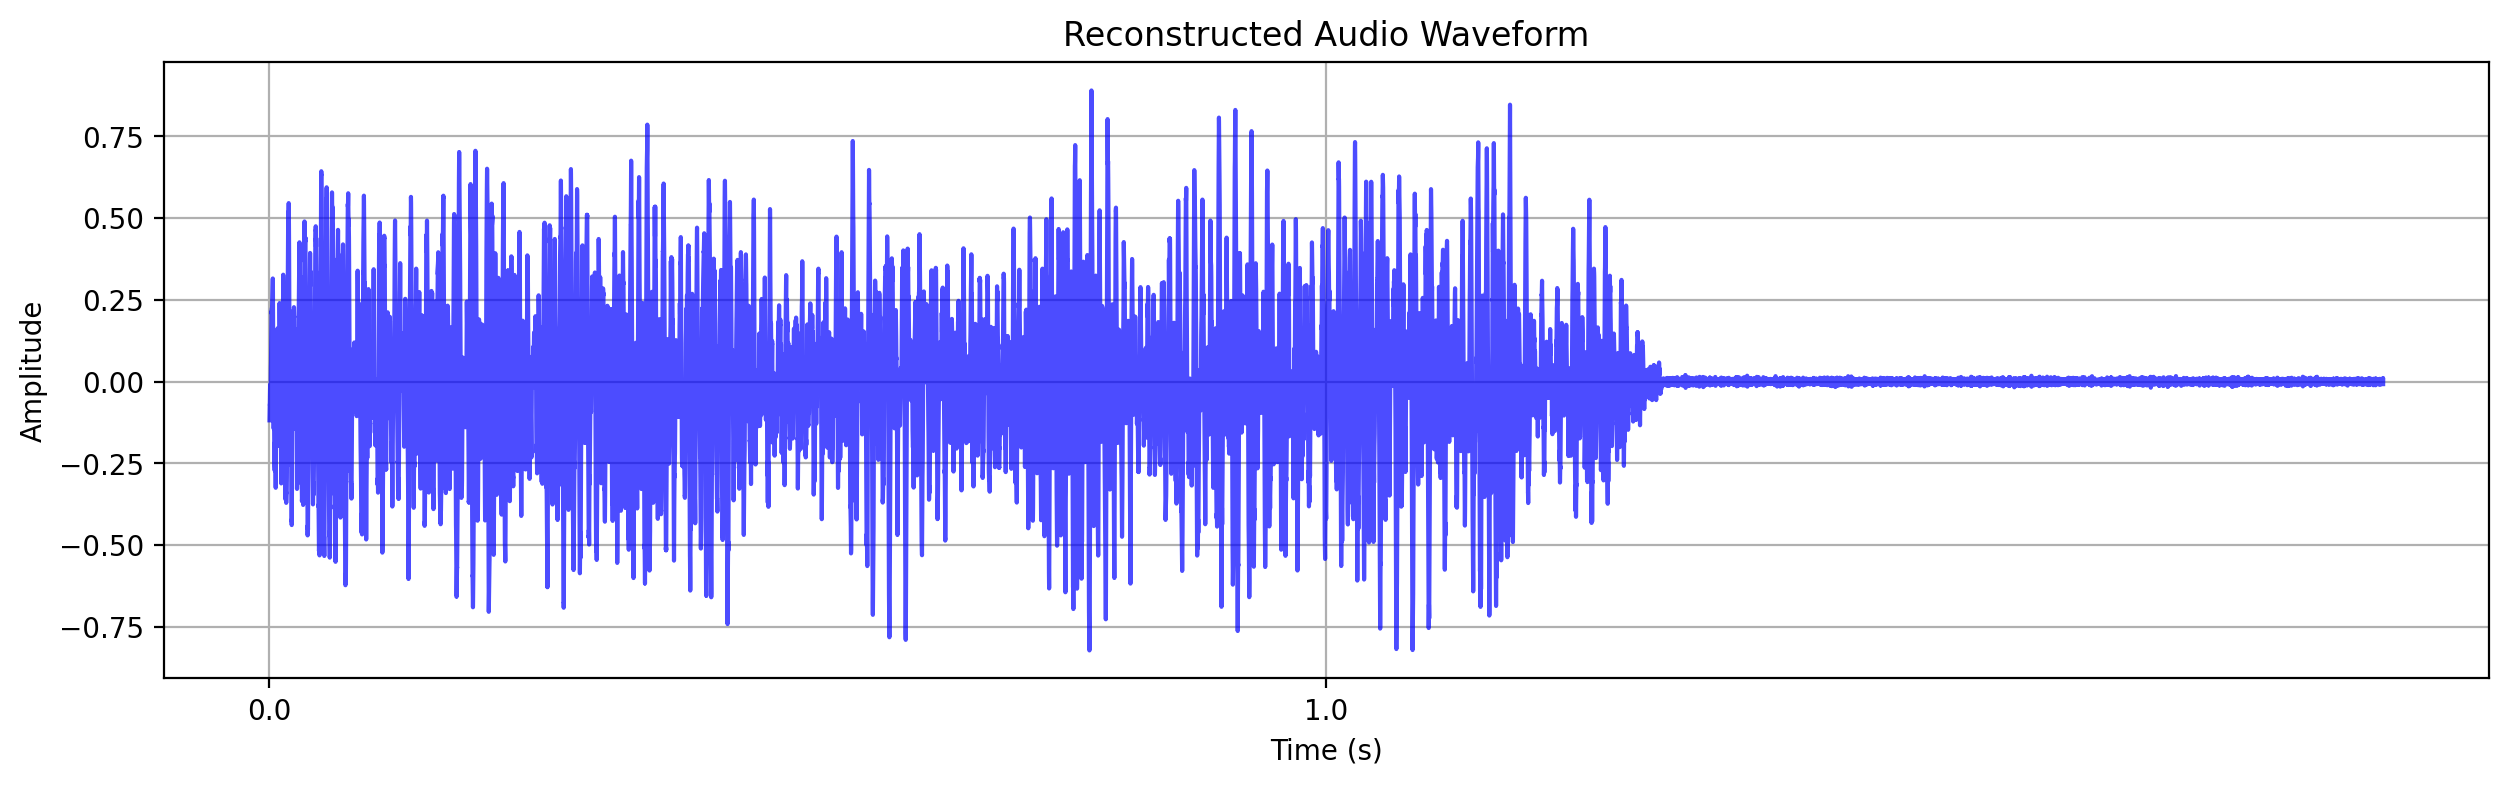

In [27]:
audio_plot(pred_audio, sr, 'blue', 'Reconstructed Audio Waveform')

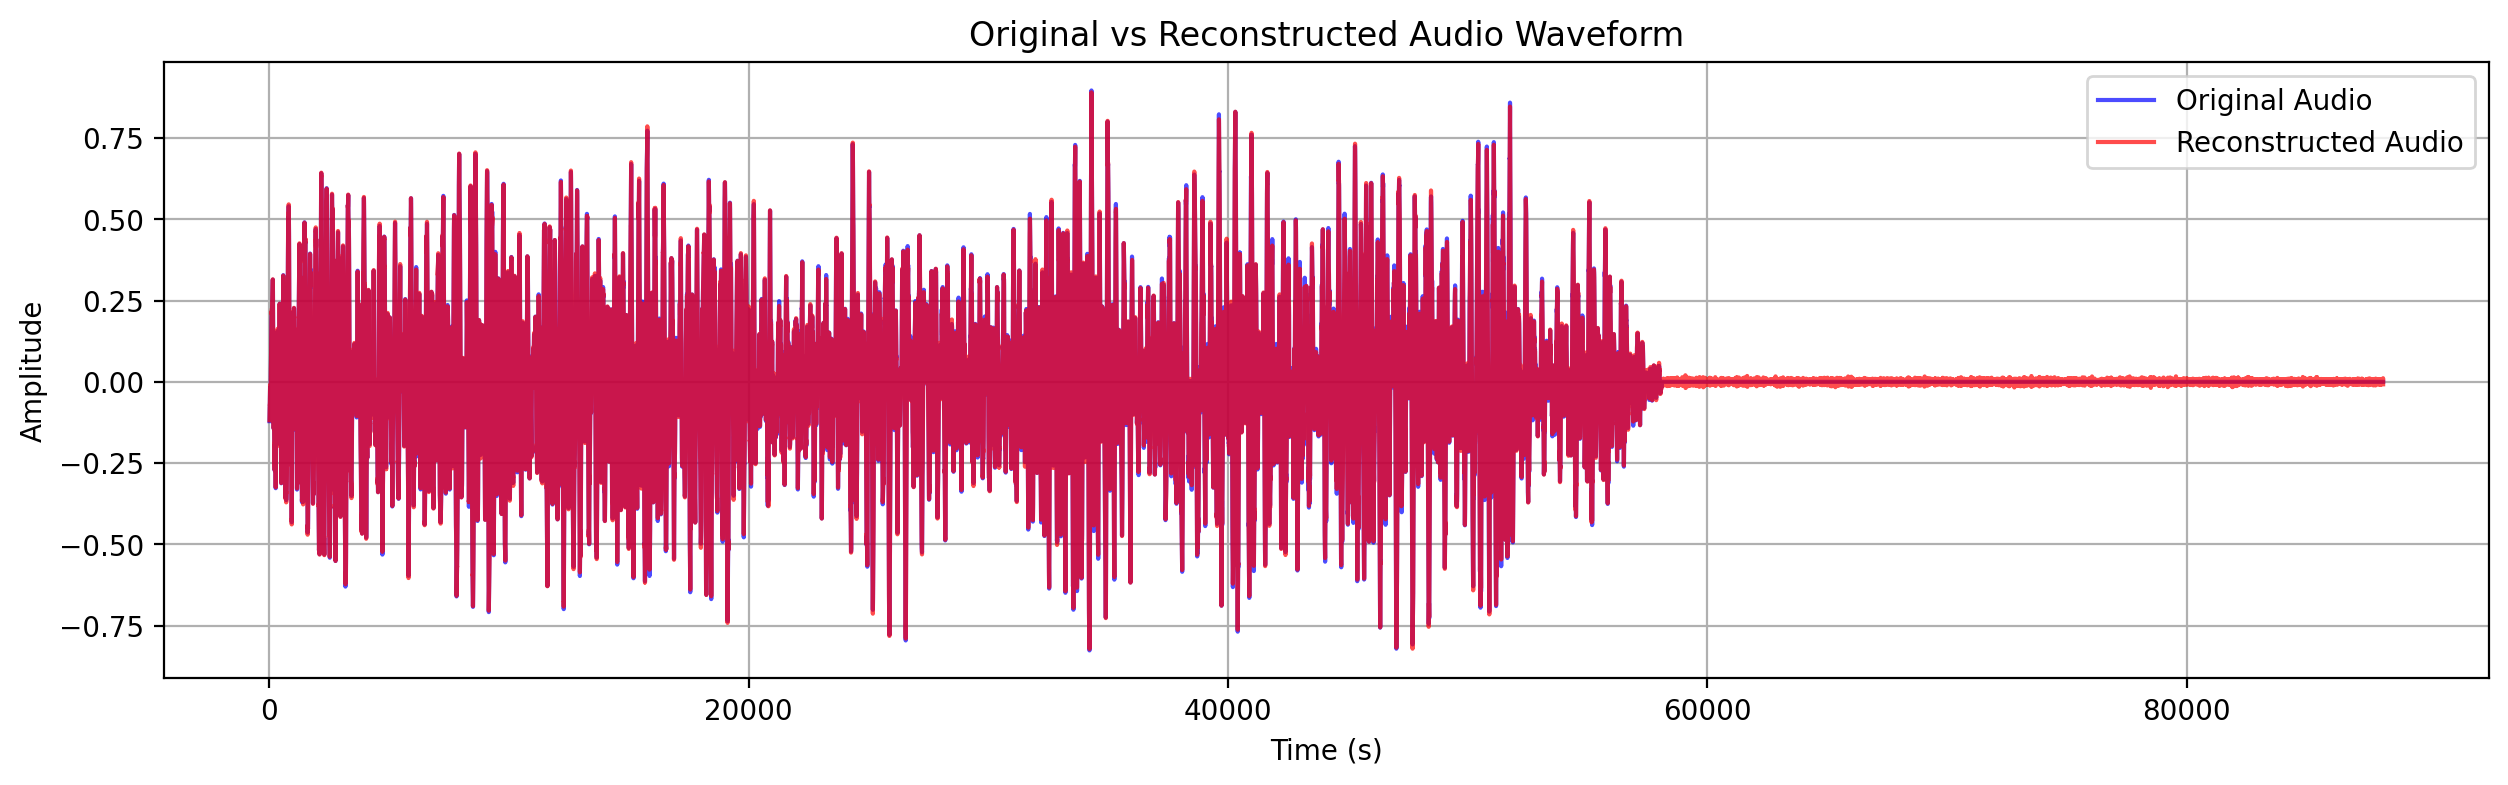

In [28]:
plt.figure(figsize=(15, 4))
plt.plot(audio, color = 'blue', alpha = 0.7, label = 'Original Audio')
plt.plot(pred_audio, color = 'red', alpha = 0.7, label = 'Reconstructed Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Audio Waveform')
plt.grid()
plt.legend()
plt.show()

In [29]:
import numpy as np
# Convert tensors to numpy arrays
audio_np = audio.numpy()
pred_audio_np = np.array(pred_audio)
# Calculate RMSE
rmse = np.sqrt(np.mean((audio_np - pred_audio_np) ** 2))
print(f"RMSE: {rmse}")
# Calculate noise
noise = audio_np - pred_audio_np
# Calculate SNR
snr = 10 * np.log10(np.mean(audio_np ** 2) / np.mean(noise ** 2))
print(f"SNR: {snr} dB")


RMSE: 0.0059971194714307785
SNR: 31.219091415405273 dB
